# 统计学习导论第八次作业
作业任务：关联分析(关联规则、购物篮分析)——Apriori算法与FP-growth算法  
mlxtend库都能实现，伟大

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
### 1.1 数据概览

In [1]:
####--------------------------------统计学习导论第八次作业——关联分析（购物篮分析）--------------------------------####

import pandas as pd 
from mlxtend.preprocessing import TransactionEncoder
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
# --------------------------------1、数据导入--------------------------------#

market_basket_df = pd.read_csv('/Users/ouyangruizhi/Desktop/python/统计学习导论/推荐算法-关联分析/BigBasketRefined.csv', header=None)  # 绝对路径
market_basket_df

,0,1,2,3,4,5,6,7,8,9
0,Other Sauces,Cashews,Namkeen,Sugar,Banana,Sugar Cubes,Other Sweets,Other Rice Products,NaN,NaN
1,Utensil Scrub Pads,Other Rice Products,Buns & Pavs,Cakes,Other Dals,Boiled Rice,NaN,NaN,NaN,NaN
2,Urad Dal,Boiled Rice,Raisins,Chips,Other Dals,Almonds,NaN,NaN,NaN,NaN
3,Sugar,Jaggery,Cakes,Urad Dal,Namkeen,Other Vegetables,Moong Dal,Banana,Other Dals,Cashews
4,Banana,Other Rice Products,Raw Peanuts,Sugar Cubes,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8381,Beans,Organic Flours,Root Vegetables,Sugar & Jaggery,Organic Dals & Pulses,Corn Snacks,Banana,NaN,NaN,NaN
8382,Bread,Root Vegetables,Organic Salt,Banana,Organic F&V,NaN,NaN,NaN,NaN,NaN
8383,Whole Spices,Glucose,Washing Bars,Bread,Snacky Nuts,Organic Masalas & Spices,Organic Flours,NaN,NaN,NaN
8384,Health Drinks,Root Vegetables,Banana,Beans,Glucose,Marie & Milk Biscuits,Organic F&V,NaN,NaN,NaN


### 1.2 数据基本情况
数据情况：最多一个人购买10件商品，一个观测买一件记一列，如购买一件及以上的人数有8386；购买两件及以上的人数有：7846；购买三件及以上的人数有：6676...购买十件的人数有104人。

In [4]:
print(market_basket_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8386 entries, 0 to 8385
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       8386 non-null   object
 1   1       7846 non-null   object
 2   2       6676 non-null   object
 3   3       5613 non-null   object
 4   4       4603 non-null   object
 5   5       3534 non-null   object
 6   6       2355 non-null   object
 7   7       1255 non-null   object
 8   8       505 non-null    object
 9   9       104 non-null    object
dtypes: object(10)
memory usage: 655.3+ KB
None


### 1.3 删除空值

In [5]:
# 删除数据列表里的空值
basket_items = []
for index, row in market_basket_df.iterrows():
    cleansed_items = [item for item in row if str(item)!='nan']
    basket_items.append(cleansed_items)

# 处理后的前三行数据
print(basket_items[:3])

[['Other Sauces', 'Cashews', 'Namkeen', 'Sugar', 'Banana', 'Sugar Cubes', 'Other Sweets', 'Other Rice Products'], ['Utensil Scrub Pads', 'Other Rice Products', 'Buns & Pavs', 'Cakes', 'Other Dals', 'Boiled Rice'], ['Urad Dal', 'Boiled Rice', 'Raisins', 'Chips', 'Other Dals', 'Almonds']]


## 二、数据探索
### 2.1 数据转换
将事物数据转换为 one-hot 编码数组，列名为各个物品，True表示购买了，False表示没购买

In [6]:
# --------------------------------2、数据探索--------------------------------#
# 数据转换，将事物数据转换为 one-hot 编码数组 列名为各个物品，True表示购买了，False表示没购买
tran_encod = TransactionEncoder()
tran_encod_list = tran_encod.fit(basket_items).transform(basket_items)
transaction_df = pd.DataFrame(tran_encod_list, columns=tran_encod.columns_)

# 前五行数据
print(transaction_df.head())

    Cookies & Rusk   Foam & Gels   Glue & Tape   Marie & Milk Biscuits  \
0            False         False         False                   False   
1            False         False         False                   False   
2            False         False         False                   False   
3            False         False         False                   False   
4            False         False         False                   False   

    Peelers & Scrapers  After Shave  Agarbatti  Almonds  \
0                False        False      False    False   
1                False        False      False    False   
2                False        False      False     True   
3                False        False      False    False   
4                False        False      False    False   

   Aluminium Foil & Cling Wrap  Antiseptics  ...  Vanaspati  Veg & Fruit  \
0                        False        False  ...      False        False   
1                        False        False  ...

### 2.2 购买频率前十商品

In [7]:
# 商品被购买次数
item_count = {}
for col in transaction_df.columns:
    item_count[col] = transaction_df[col].sum()

item_freq_df = pd.DataFrame(data=list(item_count.values()), index=list(item_count.keys()), 
                            columns=['frequency']).sort_values(by='frequency', 
                            ascending=False)

print(item_freq_df.shape, item_freq_df.head(10))

(221, 1)                   frequency
Other Vegetables       3020
Root Vegetables        2845
Beans                  2800
Gourd & Cucumber       2080
Brinjals               1845
Other Dals             1731
Banana                 1729
Whole Spices           1514
Organic F&V            1297
Namkeen                1134


### 2.3 购买频率前十商品极坐标柱状图

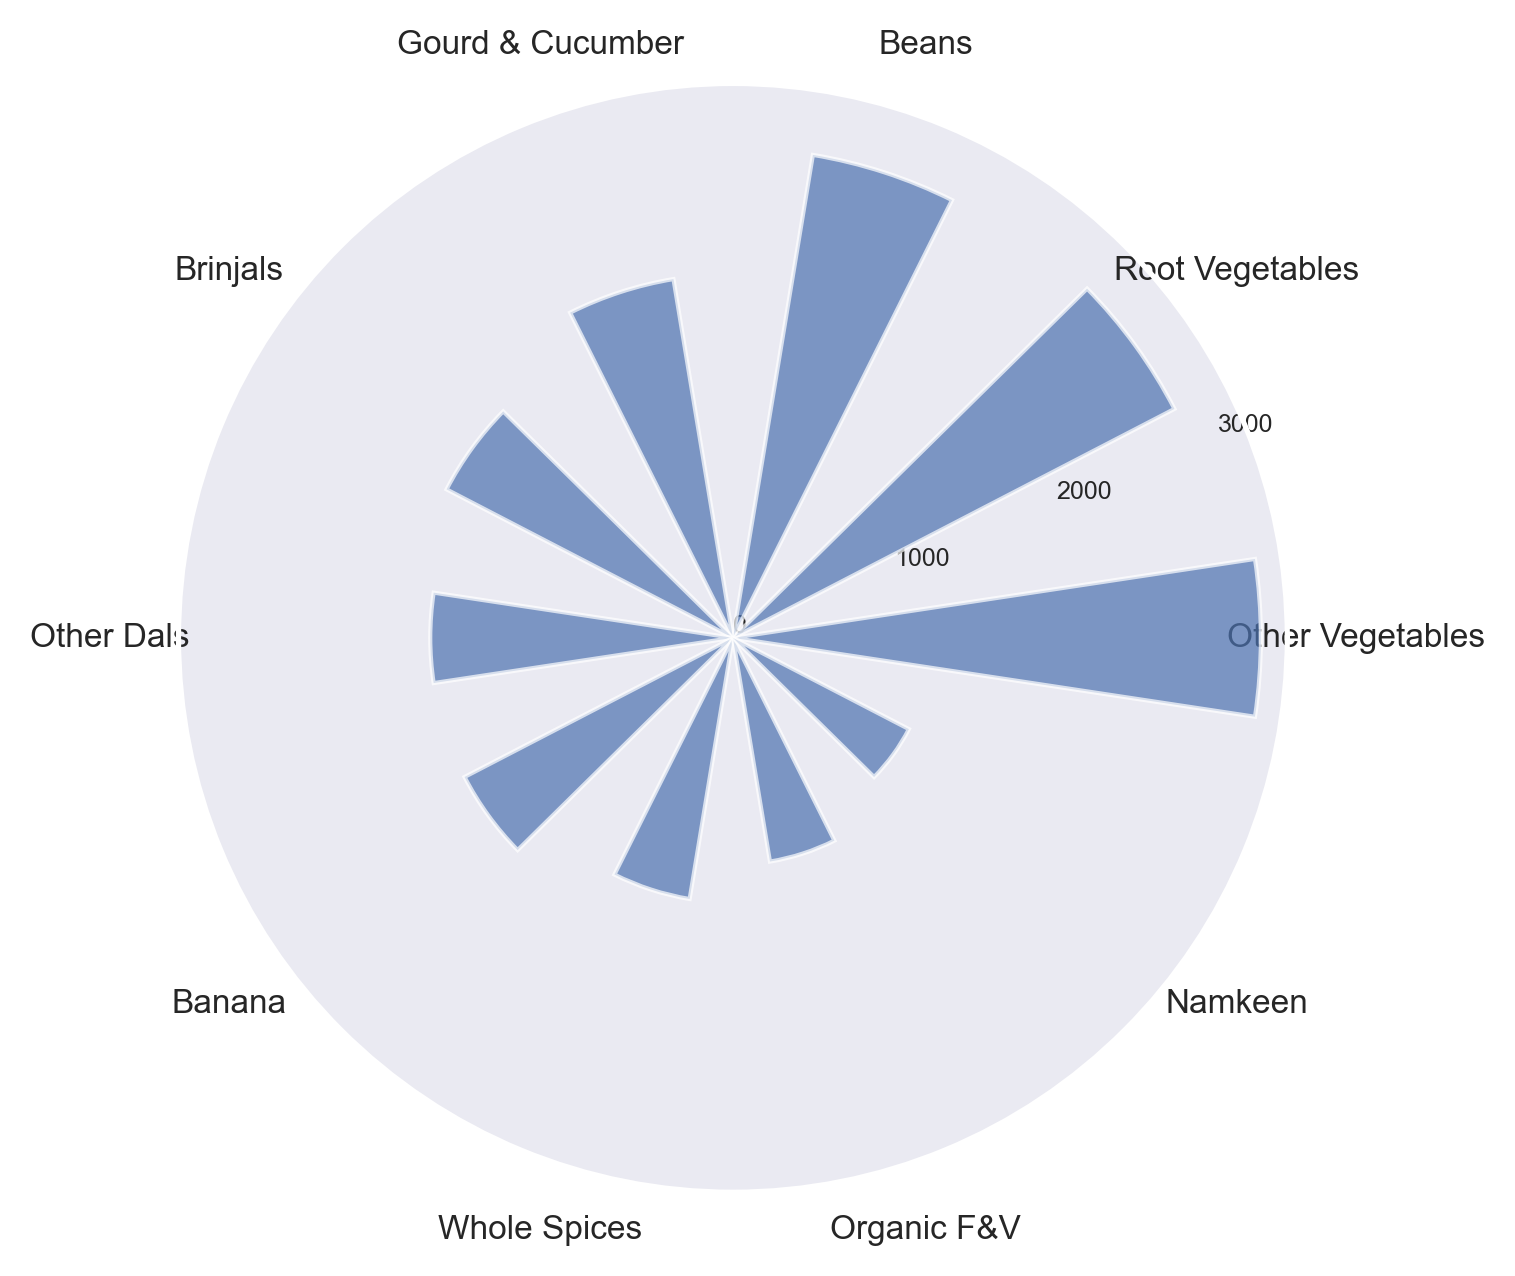

In [8]:
# 购买频率Top10频率图
sns.set_theme(font_scale=1)
top_10_item_freq_df = item_freq_df.head(10)
theta = np.linspace(0, 2 * np.pi, 10, endpoint=False)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, polar=True)

bars = ax.bar(theta, top_10_item_freq_df['frequency'].values, width=0.3, alpha=0.7, color = 'b')  # 柱子宽度、透明度、颜色

yticks = [0, 1000, 2000, 3000]
ax.set_yticks(yticks)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)  # 刻度字体大小

ax.set_xticks(theta)
ticklabels = ax.set_xticklabels(top_10_item_freq_df.index, rotation='vertical', fontsize=8) 
for label in ticklabels:
    label.set_verticalalignment('center')
    label.set_horizontalalignment('center')
    label.set_rotation_mode('anchor')

ax.grid(False)
plt.savefig(fname='购买频率TOP10图.png')

### 2.4 全部商品购买频率

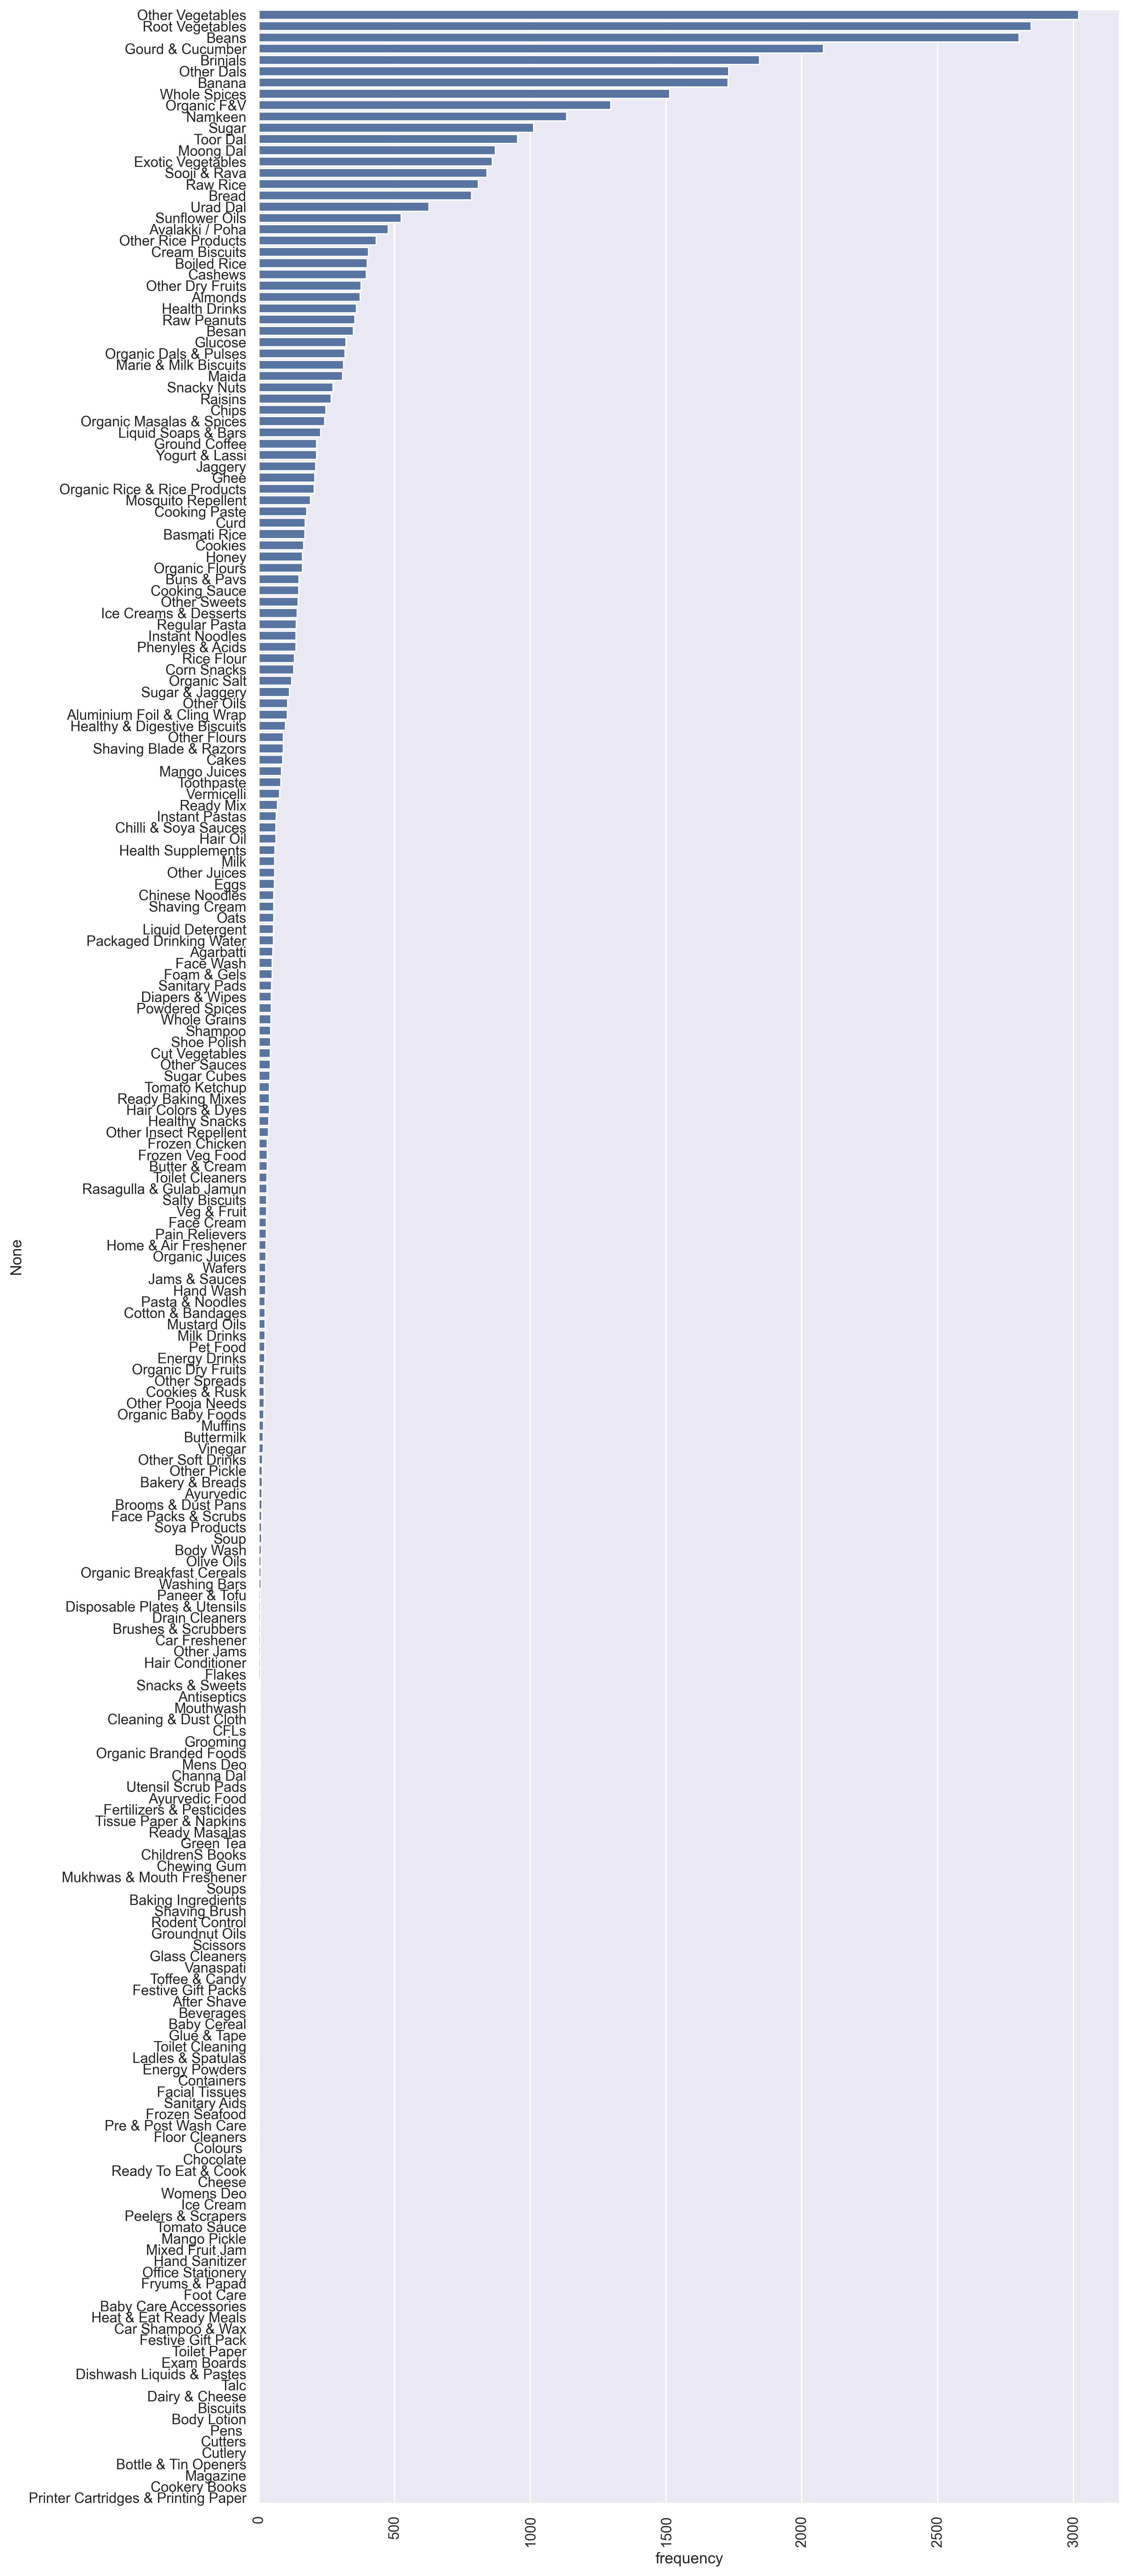

In [9]:
# 全部商品频率图
plt.figure(figsize=(12,35), dpi=300)
sns.barplot(y=item_freq_df.index, x=item_freq_df.frequency)
plt.xticks(rotation=90)
plt.savefig(fname='购买频率图.png')

### 2.5 矩形树图

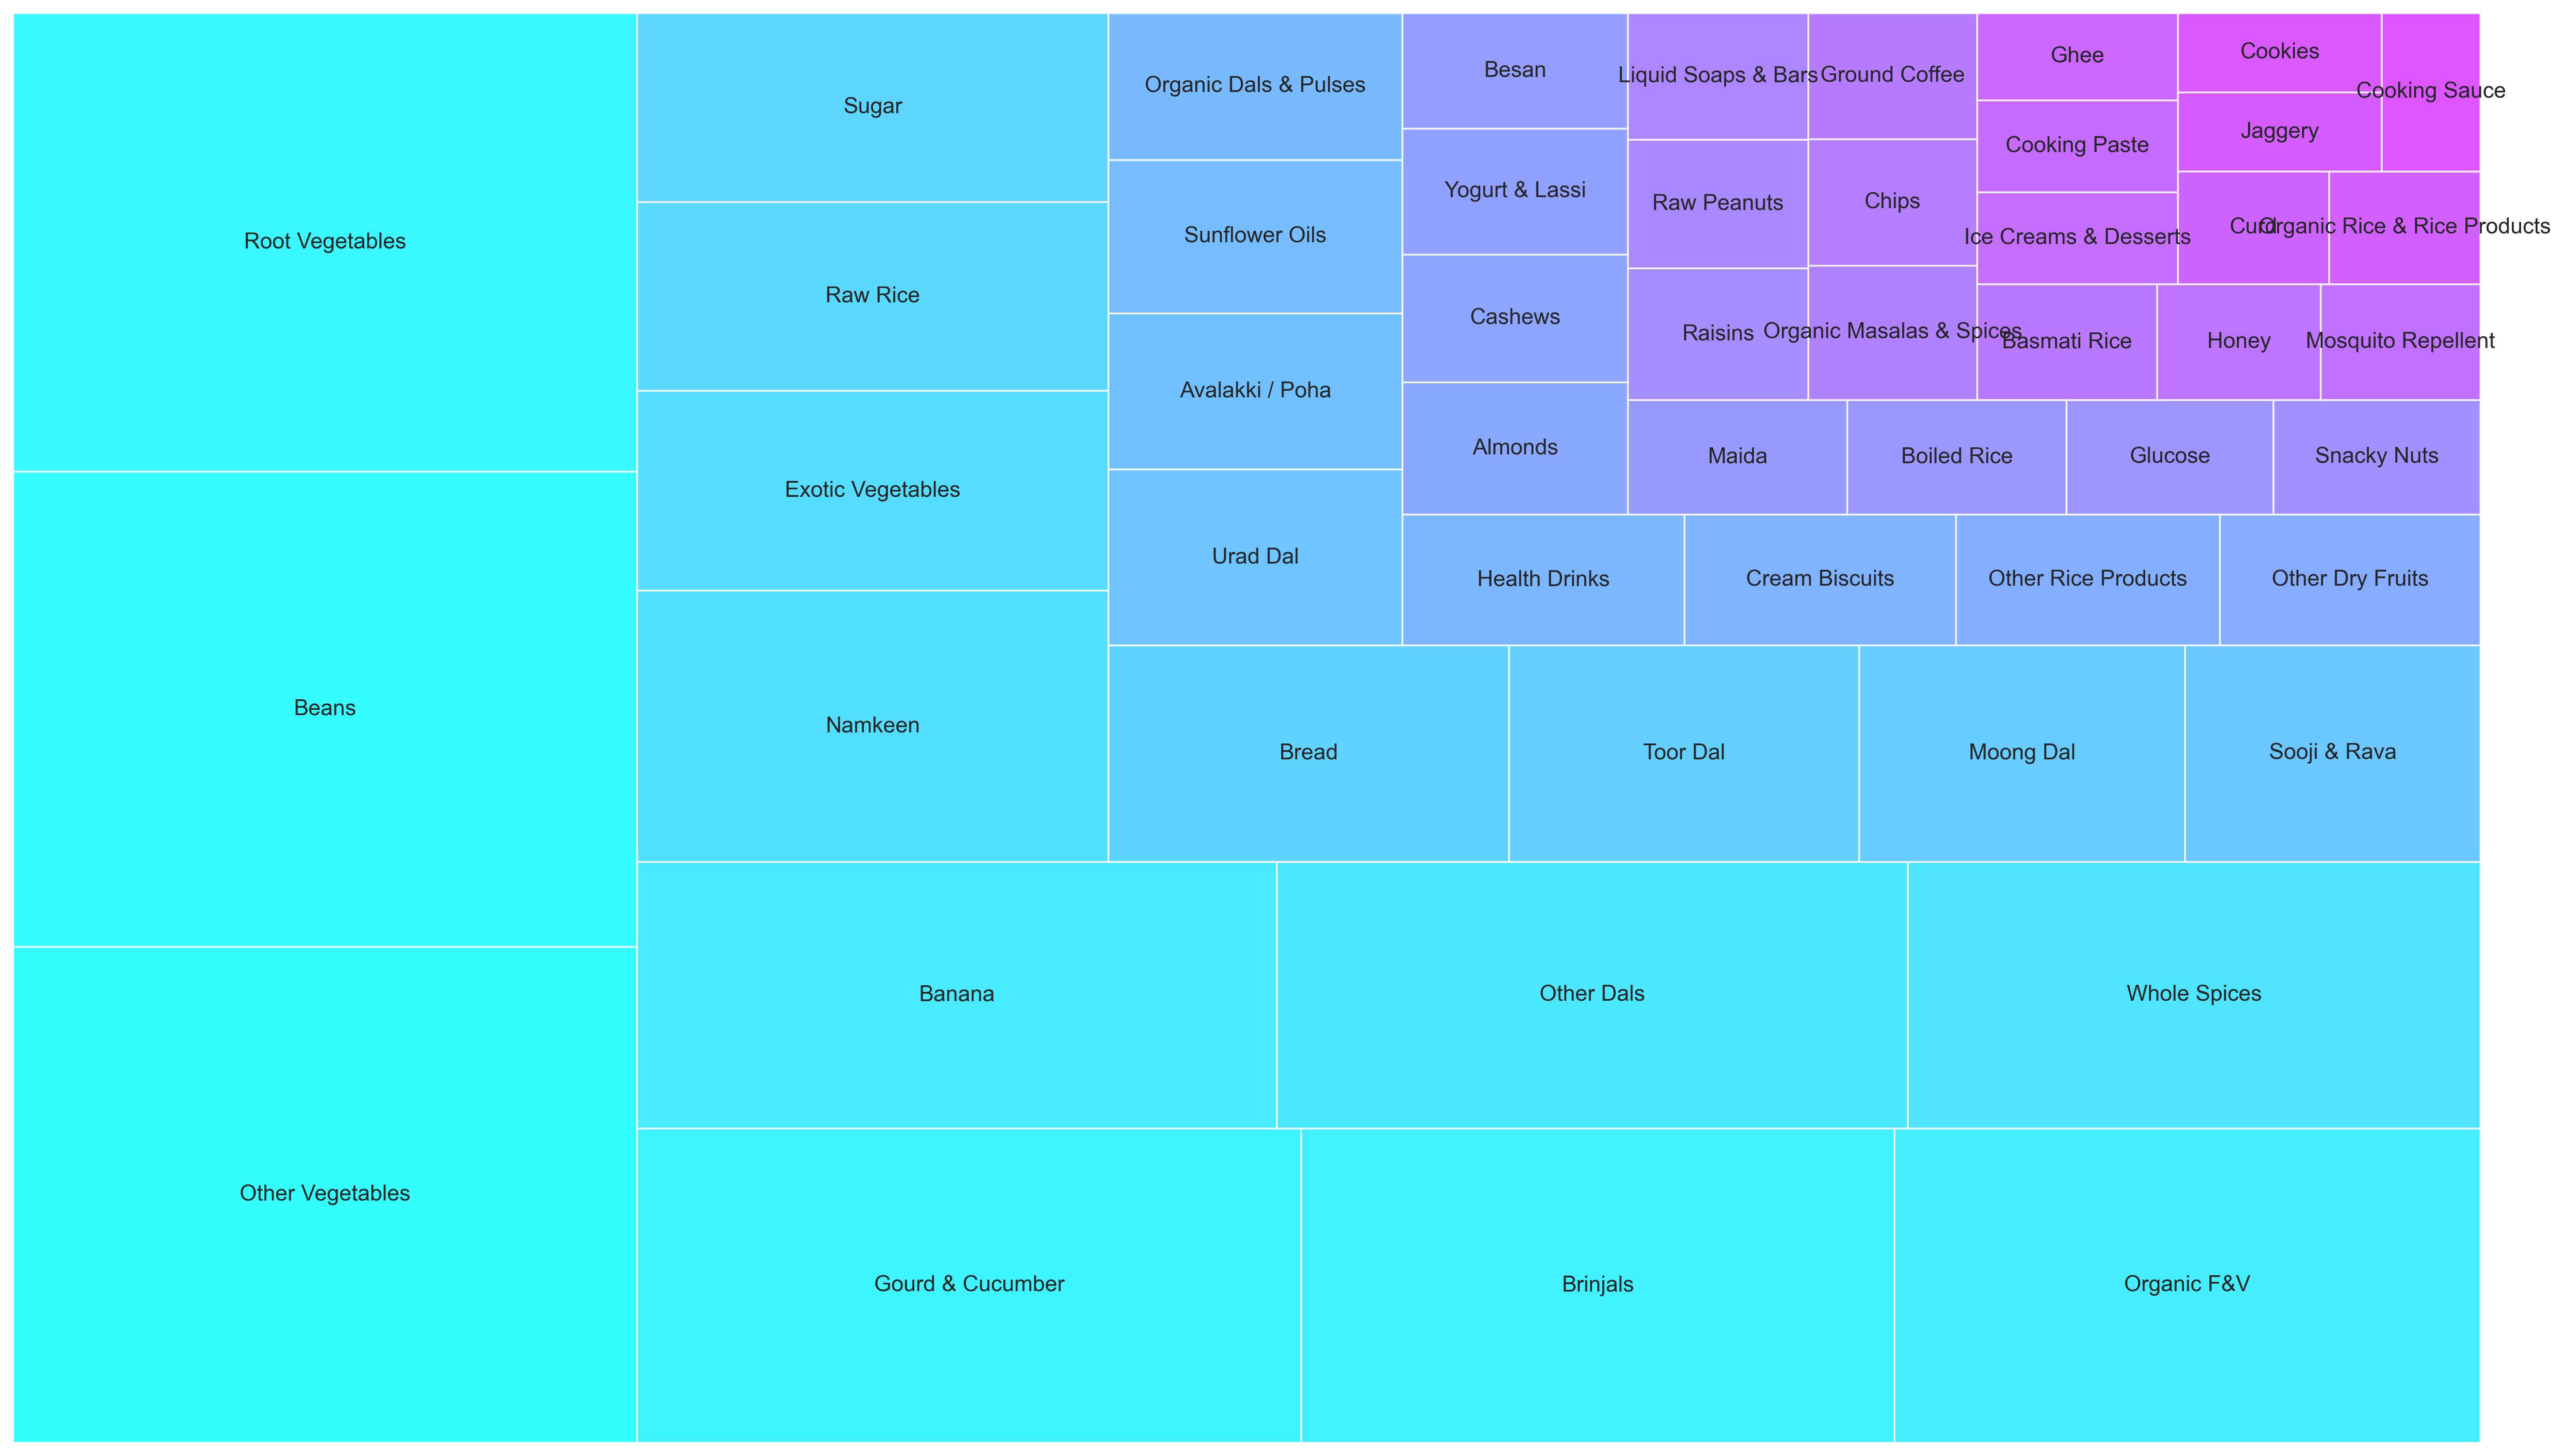

In [11]:
# 矩形树图
market_basket_df_Count = market_basket_df[0].value_counts().head(50).to_frame()

plt.figure(figsize=(24,14), dpi=300)
color = plt.cm.cool(np.linspace(0, 1, 60))
squarify.plot(sizes = market_basket_df_Count.values, label = market_basket_df_Count.index, alpha=.8, color = color)
plt.axis('off')
plt.savefig(fname='矩形树图.png')

### 2.6 词云图

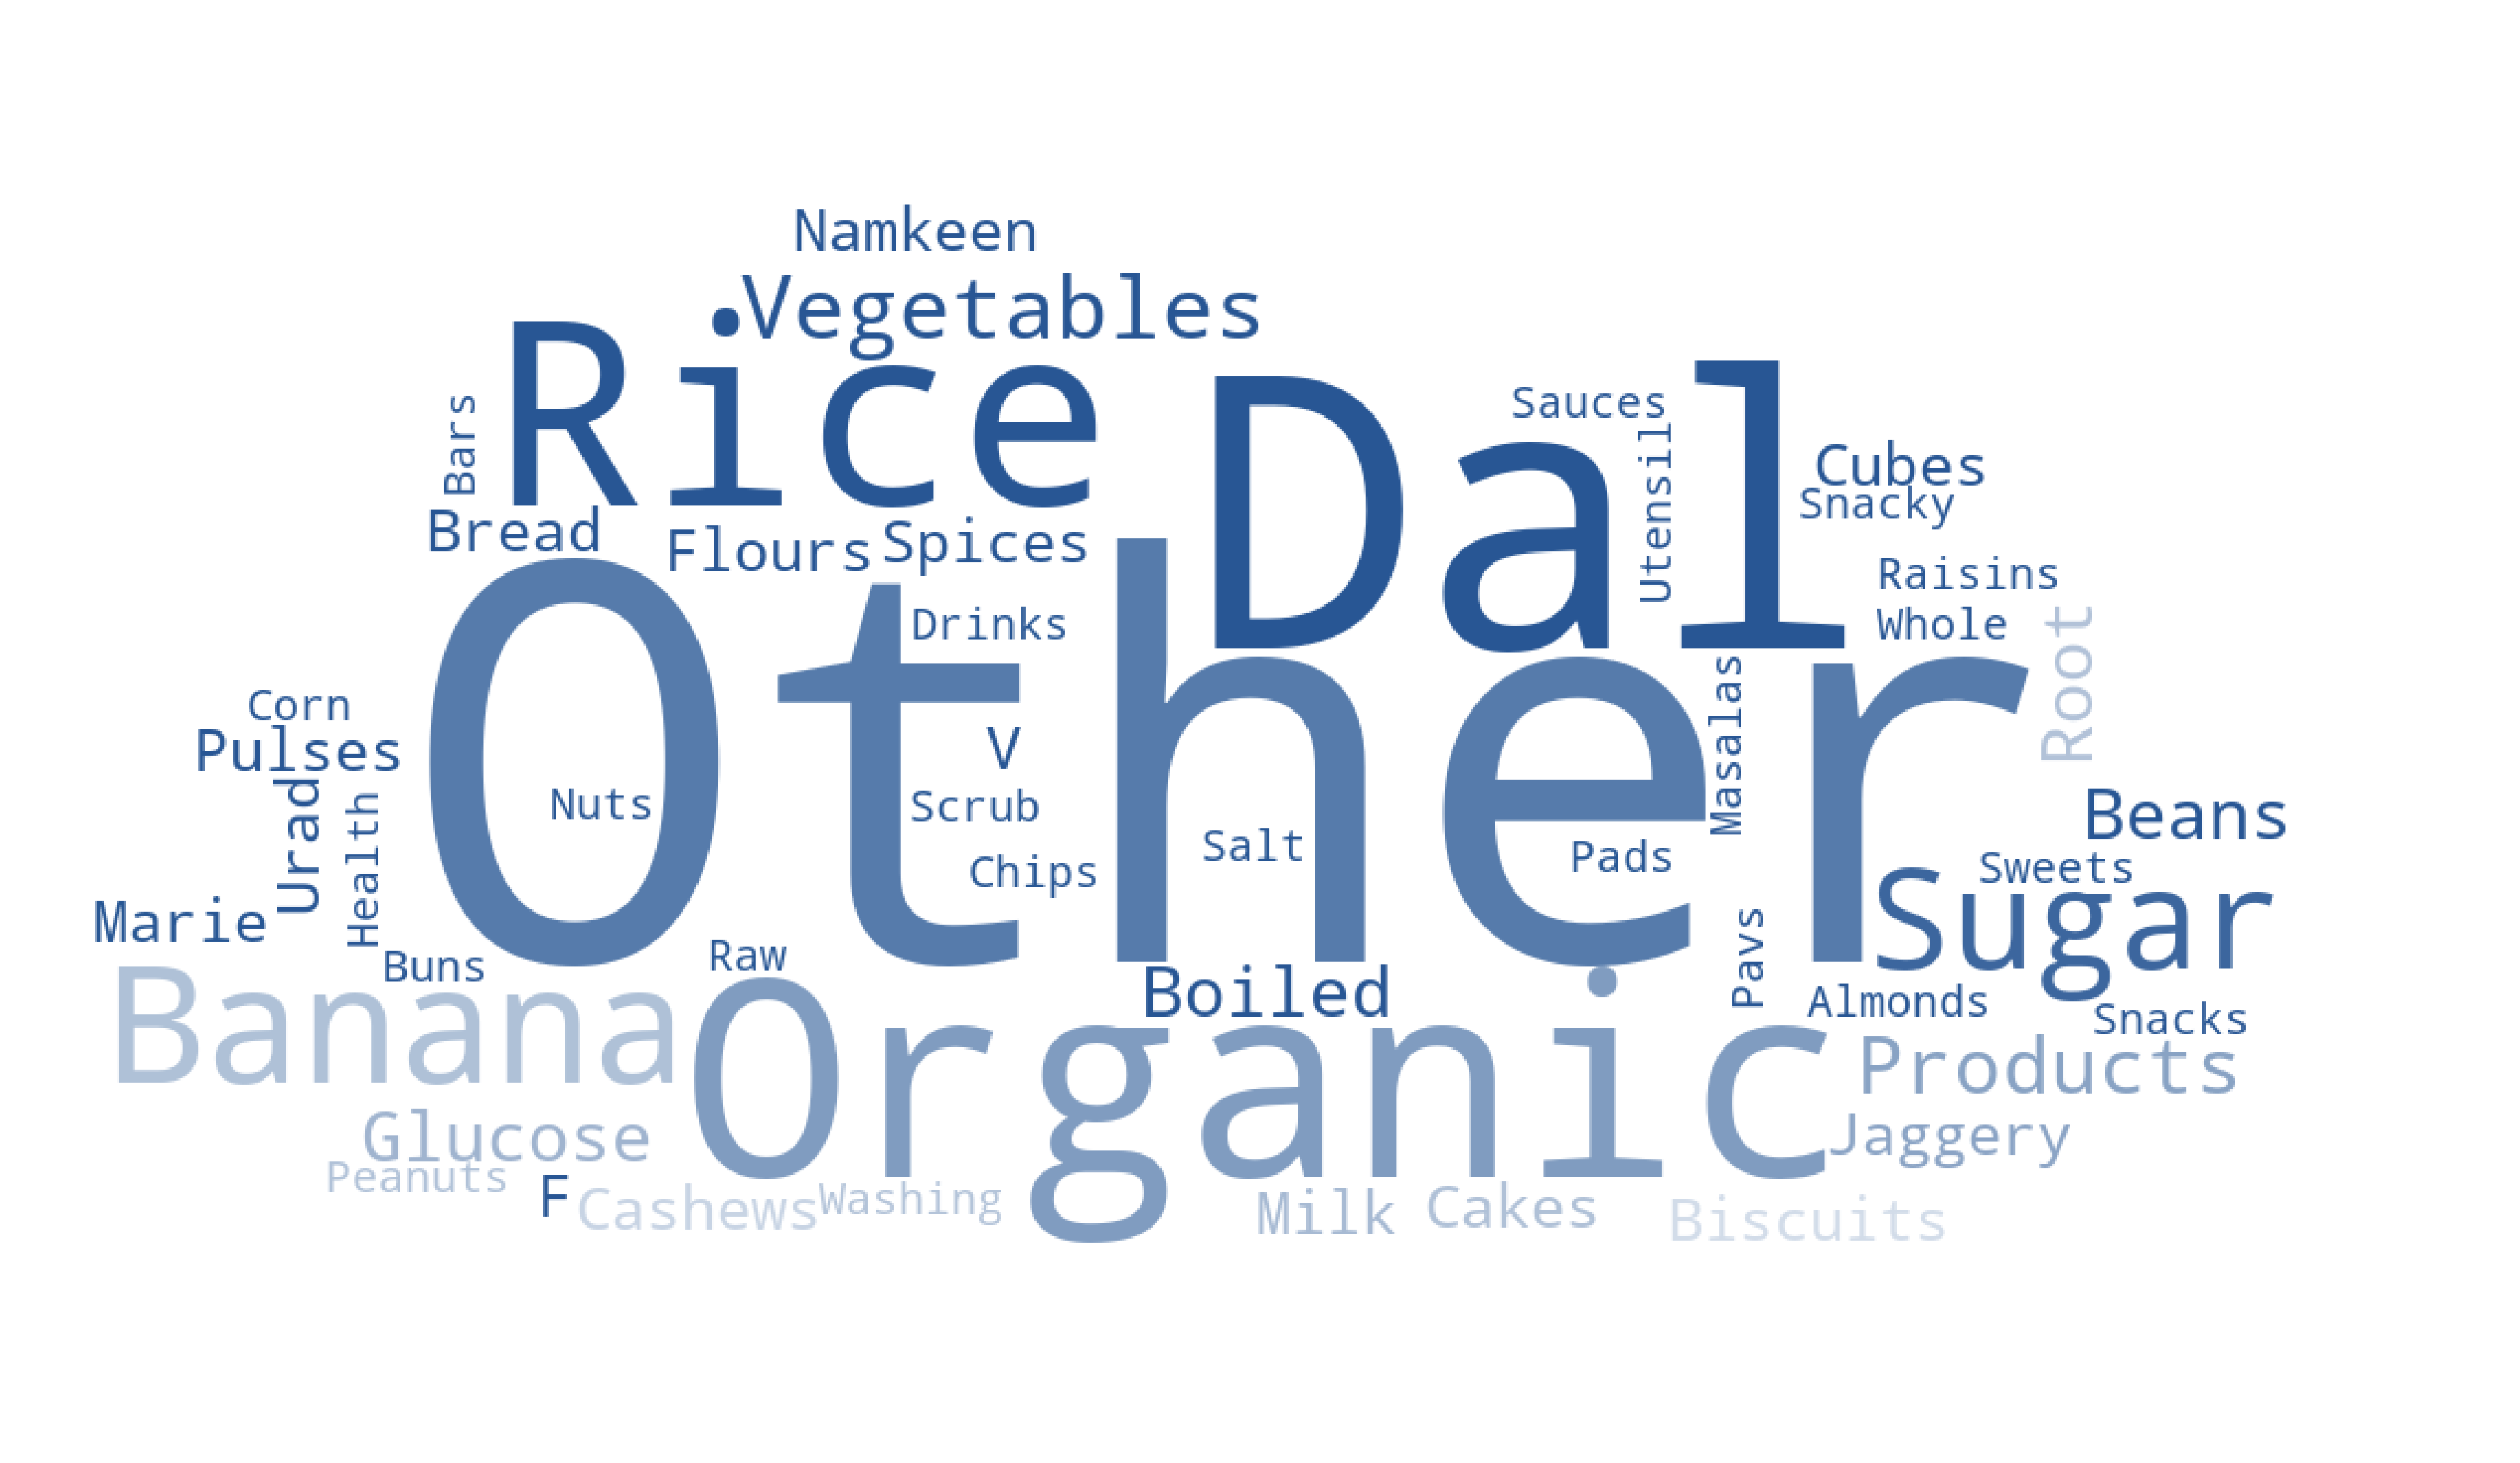

In [12]:
# 词云图
plt.figure(figsize=(16,9), dpi=300)
image = Image.open('/Users/ouyangruizhi/Desktop/python/统计学习导论/推荐算法-关联分析/云.png') 
graph = np.array(image)
image_color = ImageColorGenerator(graph)
wordcloud = WordCloud(background_color = 'white',mask=graph, max_words = 50, stopwords = ('Description', 'NAN','columns')).generate(str(market_basket_df))
cwc = wordcloud.recolor(color_func=image_color)
plt.imshow(cwc)
plt.axis('off')
plt.savefig(fname='词云图.png')

## 三、Apriori算法

### 3.1 初步确定最小支持度
初步确定为0.1

In [23]:
# --------------------------------3、Apriori算法--------------------------------#
from mlxtend.frequent_patterns import apriori, association_rules

# 计算最小支持度大于0.1支持的集合（频繁集）
support = apriori(transaction_df, min_support=0.1, use_colnames=True)
support

,support,itemsets
0,0.206177,(Banana)
1,0.333890,(Beans)
2,0.220010,(Brinjals)
3,0.102552,(Exotic Vegetables)
4,0.248032,(Gourd & Cucumber)
5,0.103983,(Moong Dal)
6,0.135225,(Namkeen)
7,0.154663,(Organic F&V)
8,0.206415,(Other Dals)
9,0.360124,(Other Vegetables)


### 3.2 高频购买商品情况

In [24]:
# 计算大于50、100、200的商品数据
print(f'freq>200: {item_freq_df[item_freq_df.frequency>200].shape[0]} items')
print(f'freq>100: {item_freq_df[item_freq_df.frequency>100].shape[0]} items')
print(f'freq>50: {item_freq_df[item_freq_df.frequency>50].shape[0]} items')

freq>200: 43 items
freq>100: 63 items
freq>50: 84 items


发现大于50的数量为84、大于100的数量为63、大于200的数量为43，而最小支持度为0.1时的数量只有21，应当进一步适当缩小支持度
### 3.3 调整最小支持度

In [25]:
# 计算最小支持度大于0.08支持的集合（频繁集）数量
freq_itemset_support = apriori(transaction_df, min_support=0.08, use_colnames=True)
print('最小支持度为0.08时，频繁集数量：',freq_itemset_support.shape[0])

# 计算最小支持度大于0.05支持的集合（频繁集）数量
freq_itemset_support = apriori(transaction_df, min_support=0.05, use_colnames=True)
print('最小支持度为0.05时，频繁集数量：',freq_itemset_support.shape[0])

# 计算最小支持度大于0.03支持的集合（频繁集）数量
freq_itemset_support = apriori(transaction_df, min_support=0.03, use_colnames=True)
print('最小支持度为0.03时，频繁集数量：',freq_itemset_support.shape[0])

最小支持度为0.08时，频繁集数量： 28
最小支持度为0.05时，频繁集数量： 52
最小支持度为0.03时，频繁集数量： 111


因此选择最小支持度为0.03合适一点
### 3.4 计算频繁集

In [36]:
# 计算最小支持度大于0.03支持的集合（频繁集）
freq_itemset_support

,support,itemsets
0,0.037205,( Marie & Milk Biscuits)
1,0.044598,(Almonds)
2,0.056881,(Avalakki / Poha)
3,0.206177,(Banana)
4,0.333890,(Beans)
...,...,...
106,0.039590,"(Gourd & Cucumber, Brinjals, Root Vegetables)"
107,0.052230,"(Brinjals, Other Vegetables, Root Vegetables)"
108,0.061173,"(Gourd & Cucumber, Other Vegetables, Root Vege..."
109,0.031123,"(Other Dals, Other Vegetables, Root Vegetables)"


### 3.5 选择置信度大于0.4进行关联分析

In [27]:
# 选择置信度为0.4进行关联分析
num_itemsets = freq_itemset_support.shape[0]
overal_association_rules = association_rules(freq_itemset_support, num_itemsets, metric="confidence", min_threshold=0.4)
overal_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Banana),(Root Vegetables),0.206177,0.339256,0.082757,0.401388,1.183143,1.0,0.012810,1.103794,0.194997,0.178866,0.094034,0.322662
1,(Brinjals),(Beans),0.220010,0.333890,0.099809,0.453659,1.358707,1.0,0.026350,1.219220,0.338474,0.219800,0.179803,0.376294
2,(Gourd & Cucumber),(Beans),0.248032,0.333890,0.126043,0.508173,1.521978,1.0,0.043228,1.354359,0.456084,0.276484,0.261643,0.442837
3,(Other Vegetables),(Beans),0.360124,0.333890,0.162294,0.450662,1.349733,1.0,0.042053,1.212569,0.404942,0.305225,0.175305,0.468367
4,(Beans),(Other Vegetables),0.333890,0.360124,0.162294,0.486071,1.349733,1.0,0.042053,1.245068,0.388994,0.305225,0.196831,0.468367
5,(Root Vegetables),(Beans),0.339256,0.333890,0.153709,0.453076,1.356961,1.0,0.040434,1.217920,0.398126,0.295914,0.178928,0.456716
6,(Beans),(Root Vegetables),0.333890,0.339256,0.153709,0.460357,1.356961,1.0,0.040434,1.224410,0.394919,0.295914,0.183280,0.456716
7,(Brinjals),(Gourd & Cucumber),0.220010,0.248032,0.089793,0.408130,1.645471,1.0,0.035223,1.270495,0.502918,0.237390,0.212905,0.385075
8,(Brinjals),(Other Vegetables),0.220010,0.360124,0.114715,0.521409,1.447860,1.0,0.035484,1.337000,0.396576,0.246477,0.252057,0.419976
9,(Brinjals),(Root Vegetables),0.220010,0.339256,0.093489,0.424932,1.252542,1.0,0.018850,1.148985,0.258495,0.200717,0.129666,0.350252


### 3.6 去除热门商品的关联分析
#### 3.6.1 去除热门商品Other Vegetables

In [28]:
trans_Other_Vegetables_df = transaction_df.drop(columns=['Other Vegetables'])

#### 3.6.2 选择最小支持度并计算频繁集

In [30]:
# 计算最小支持度大于0.03支持的集合（频繁集）
freq_itemset_Other_Vegetables_supp = apriori(trans_Other_Vegetables_df, min_support=0.03, use_colnames=True)
freq_itemset_Other_Vegetables_supp

,support,itemsets
0,0.037205,( Marie & Milk Biscuits)
1,0.044598,(Almonds)
2,0.056881,(Avalakki / Poha)
3,0.206177,(Banana)
4,0.333890,(Beans)
...,...,...
78,0.036966,"(Banana, Beans, Root Vegetables)"
79,0.046864,"(Gourd & Cucumber, Brinjals, Beans)"
80,0.044479,"(Brinjals, Beans, Root Vegetables)"
81,0.059504,"(Gourd & Cucumber, Beans, Root Vegetables)"


#### 3.6.3 选择置信度并进行关联分析

In [31]:
# 选择置信度为0.4进行关联分析
num_itemsets = freq_itemset_support.shape[0]
Other_Vegetables_assoc_rules = association_rules(freq_itemset_Other_Vegetables_supp, num_itemsets, metric="confidence", min_threshold=0.4)

#### 3.6.4 结果按支持度排序

In [34]:
Other_Vegetables_assoc_rules.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Beans),(Root Vegetables),0.333890,0.339256,0.153709,0.460357,1.356961,1.0,0.040434,1.224410,0.394919,0.295914,0.183280,0.456716
4,(Root Vegetables),(Beans),0.339256,0.333890,0.153709,0.453076,1.356961,1.0,0.040434,1.217920,0.398126,0.295914,0.178928,0.456716
2,(Gourd & Cucumber),(Beans),0.248032,0.333890,0.126043,0.508173,1.521978,1.0,0.043228,1.354359,0.456084,0.276484,0.261643,0.442837
8,(Gourd & Cucumber),(Root Vegetables),0.248032,0.339256,0.106964,0.431250,1.271164,1.0,0.022818,1.161748,0.283682,0.222691,0.139228,0.373270
1,(Brinjals),(Beans),0.220010,0.333890,0.099809,0.453659,1.358707,1.0,0.026350,1.219220,0.338474,0.219800,0.179803,0.376294
6,(Brinjals),(Root Vegetables),0.220010,0.339256,0.093489,0.424932,1.252542,1.0,0.018850,1.148985,0.258495,0.200717,0.129666,0.350252
5,(Brinjals),(Gourd & Cucumber),0.220010,0.248032,0.089793,0.408130,1.645471,1.0,0.035223,1.270495,0.502918,0.237390,0.212905,0.385075
0,(Banana),(Root Vegetables),0.206177,0.339256,0.082757,0.401388,1.183143,1.0,0.012810,1.103794,0.194997,0.178866,0.094034,0.322662
17,"(Gourd & Cucumber, Root Vegetables)",(Beans),0.106964,0.333890,0.059504,0.556299,1.666115,1.0,0.023790,1.501258,0.447688,0.156035,0.333892,0.367257
16,"(Gourd & Cucumber, Beans)",(Root Vegetables),0.126043,0.339256,0.059504,0.472091,1.391548,1.0,0.016743,1.251625,0.321956,0.146635,0.201038,0.323743


##### 结果表明：  
在客人买了 __Beans__ 时，在support为15.37%和confidence46.04%的情况下可以给他推荐 __Root Vegetables__；  
在客人买了 __Root Vegetables__ 时，在support为15.37%和confidence45.31%的情况下可以给他推荐 __Root Vegetables__；  
因此，在商超中，将 __Beans__ 和 __Root Vegetables__ 放在一起。

## 四、FP-growth算法

### 4.1 调整最小支持度

In [35]:
# --------------------------------4、FP-growth算法--------------------------------#
from mlxtend.frequent_patterns import fpgrowth

# 计算最小支持度大于0.1支持的集合（频繁集）数量
frequent_itemsets=fpgrowth(transaction_df,min_support=0.1,use_colnames=True)
print(frequent_itemsets.shape[0])
# 计算最小支持度大于0.08支持的集合（频繁集）数量
frequent_itemsets = fpgrowth(transaction_df, min_support=0.08, use_colnames=True)
print(frequent_itemsets.shape[0])
# 计算最小支持度大于0.05支持的集合（频繁集）数量
frequent_itemsets = fpgrowth(transaction_df, min_support=0.05, use_colnames=True)
print(frequent_itemsets.shape[0])
# frequent_itemsets.03支持的集合（频繁集）数量
frequent_itemsets = fpgrowth(transaction_df, min_support=0.03, use_colnames=True)
print(frequent_itemsets.shape[0])

22
28
52
111


大于50的数量为84、大于100的数量为63、大于200的数量为43，而最小支持度为0.03时的数量有111，相对合理

### 4.2 计算频繁集

In [37]:
freq_itemset_support

,support,itemsets
0,0.037205,( Marie & Milk Biscuits)
1,0.044598,(Almonds)
2,0.056881,(Avalakki / Poha)
3,0.206177,(Banana)
4,0.333890,(Beans)
...,...,...
106,0.039590,"(Gourd & Cucumber, Brinjals, Root Vegetables)"
107,0.052230,"(Brinjals, Other Vegetables, Root Vegetables)"
108,0.061173,"(Gourd & Cucumber, Other Vegetables, Root Vege..."
109,0.031123,"(Other Dals, Other Vegetables, Root Vegetables)"


### 4.3 选择置信度并做关联分析

In [39]:
# 选择置信度为0.4进行关联分析
num_itemsets = freq_itemset_support.shape[0]
overal_association_rules = association_rules(freq_itemset_support, num_itemsets, metric="confidence", min_threshold=0.5)
overal_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Gourd & Cucumber),(Beans),0.248032,0.333890,0.126043,0.508173,1.521978,1.0,0.043228,1.354359,0.456084,0.276484,0.261643,0.442837
1,(Brinjals),(Other Vegetables),0.220010,0.360124,0.114715,0.521409,1.447860,1.0,0.035484,1.337000,0.396576,0.246477,0.252057,0.419976
2,(Gourd & Cucumber),(Other Vegetables),0.248032,0.360124,0.132602,0.534615,1.484531,1.0,0.043280,1.374940,0.434044,0.278837,0.272696,0.451414
3,"(Gourd & Cucumber, Brinjals)",(Beans),0.089793,0.333890,0.046864,0.521912,1.563127,1.0,0.016883,1.393280,0.395796,0.124367,0.282269,0.331135
4,"(Brinjals, Beans)",(Other Vegetables),0.099809,0.360124,0.054496,0.545998,1.516138,1.0,0.018552,1.409411,0.378175,0.134412,0.290484,0.348661
5,"(Gourd & Cucumber, Other Vegetables)",(Beans),0.132602,0.333890,0.072740,0.548561,1.642941,1.0,0.028466,1.475527,0.451160,0.184737,0.322276,0.383209
6,"(Gourd & Cucumber, Beans)",(Other Vegetables),0.126043,0.360124,0.072740,0.577105,1.602517,1.0,0.027349,1.513085,0.430207,0.175945,0.339099,0.389546
7,"(Gourd & Cucumber, Root Vegetables)",(Beans),0.106964,0.333890,0.059504,0.556299,1.666115,1.0,0.023790,1.501258,0.447688,0.156035,0.333892,0.367257
8,"(Gourd & Cucumber, Brinjals)",(Other Vegetables),0.089793,0.360124,0.051991,0.579017,1.607827,1.0,0.019655,1.519958,0.415337,0.130656,0.342087,0.361694
9,"(Brinjals, Root Vegetables)",(Other Vegetables),0.093489,0.360124,0.052230,0.558673,1.551336,1.0,0.018562,1.449892,0.392047,0.130125,0.310294,0.351853


### 4.4 去除热门商品的影响分析
#### 4.4.1 去除热门商品Other Vegetables
3.6.1 已完成
#### 4.4.2 确定最小支持度并计算频繁集

In [40]:
## 去除热门商品的影响分析
# 计算最小支持度大于0.03支持的集合（频繁集）
freq_itemset_Other_Vegetables_supp = fpgrowth(trans_Other_Vegetables_df, min_support=0.03, use_colnames=True)
freq_itemset_Other_Vegetables_supp

,support,itemsets
0,0.206177,(Banana)
1,0.135225,(Namkeen)
2,0.120677,(Sugar)
3,0.051634,(Other Rice Products)
4,0.047341,(Cashews)
...,...,...
78,0.039590,"(Gourd & Cucumber, Brinjals, Root Vegetables)"
79,0.033866,"(Sooji & Rava, Beans)"
80,0.031004,"(Sooji & Rava, Whole Spices)"
81,0.031481,"(Exotic Vegetables, Beans)"


#### 4.4.3 确定置信度并做关联分析

In [41]:
# 选择置信度为0.4进行关联分析
num_itemsets = freq_itemset_support.shape[0]
Other_Vegetables_assoc_rules = association_rules(freq_itemset_Other_Vegetables_supp, num_itemsets, metric="confidence", min_threshold=0.4)

#### 4.4.4 结果按支持度排序

In [44]:
# 结果按支持度排序
Other_Vegetables_assoc_rules.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(Beans),(Root Vegetables),0.333890,0.339256,0.153709,0.460357,1.356961,1.0,0.040434,1.224410,0.394919,0.295914,0.183280,0.456716
5,(Root Vegetables),(Beans),0.339256,0.333890,0.153709,0.453076,1.356961,1.0,0.040434,1.217920,0.398126,0.295914,0.178928,0.456716
7,(Gourd & Cucumber),(Beans),0.248032,0.333890,0.126043,0.508173,1.521978,1.0,0.043228,1.354359,0.456084,0.276484,0.261643,0.442837
6,(Gourd & Cucumber),(Root Vegetables),0.248032,0.339256,0.106964,0.431250,1.271164,1.0,0.022818,1.161748,0.283682,0.222691,0.139228,0.373270
10,(Brinjals),(Beans),0.220010,0.333890,0.099809,0.453659,1.358707,1.0,0.026350,1.219220,0.338474,0.219800,0.179803,0.376294
11,(Brinjals),(Root Vegetables),0.220010,0.339256,0.093489,0.424932,1.252542,1.0,0.018850,1.148985,0.258495,0.200717,0.129666,0.350252
12,(Brinjals),(Gourd & Cucumber),0.220010,0.248032,0.089793,0.408130,1.645471,1.0,0.035223,1.270495,0.502918,0.237390,0.212905,0.385075
0,(Banana),(Root Vegetables),0.206177,0.339256,0.082757,0.401388,1.183143,1.0,0.012810,1.103794,0.194997,0.178866,0.094034,0.322662
8,"(Gourd & Cucumber, Beans)",(Root Vegetables),0.126043,0.339256,0.059504,0.472091,1.391548,1.0,0.016743,1.251625,0.321956,0.146635,0.201038,0.323743
9,"(Gourd & Cucumber, Root Vegetables)",(Beans),0.106964,0.333890,0.059504,0.556299,1.666115,1.0,0.023790,1.501258,0.447688,0.156035,0.333892,0.367257


##### 结果表明：  
在客人买了 __Beans__ 时，在support为15.37%和confidence46.04%的情况下可以给他推荐 __Root Vegetables__；  
在客人买了 __Root Vegetables__ 时，在support为15.37%和confidence45.31%的情况下可以给他推荐 __Root Vegetables__；  
因此，在商超中，将 __Beans__ 和 __Root Vegetables__ 放在一起。